In [1]:
import scipy as sp
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import plotly.express as px
%matplotlib inline
import matplotlib.pyplot as plt

sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [38]:
london = 'london.csv'
lon = pd.read_csv(london)
lon.timestamp = pd.to_datetime(lon['timestamp'])
lon

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


Для начала попробуем посмотреть на число поездок по датам и времени. Постройте график, где:

по оси x – дата (timestamp)
по оси y – число поездок (cnt)

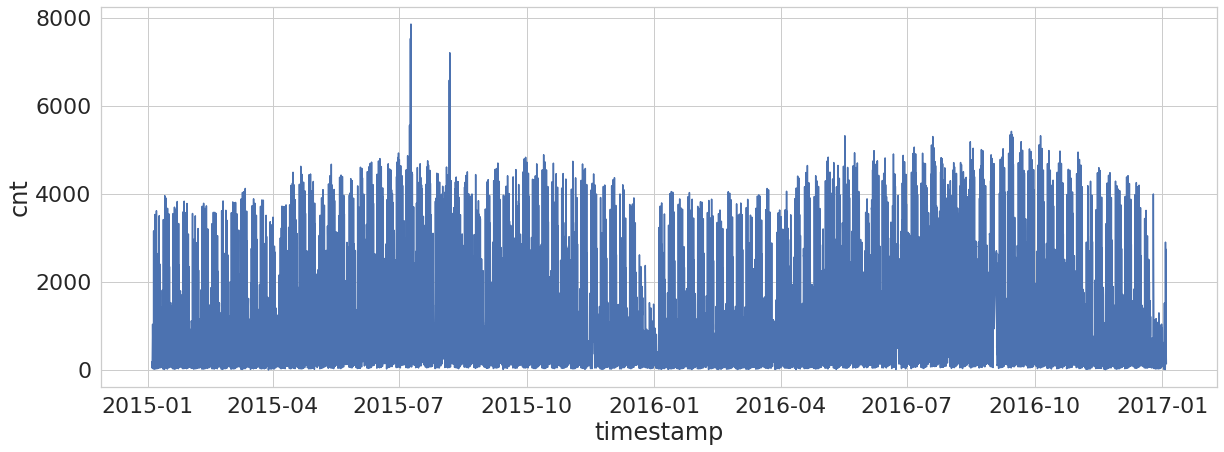

In [23]:
sns.lineplot(x = 'timestamp', y = 'cnt', data = lon)

Отлично! Предположим, что данные действительно нужно немного преобразовать. В этом нам поможет resample, с которым вы могли столкнуться в дополнительных темах pandas. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут. Например, посчитать сумму показателя по дням, имея данные по часам, можно следующим образом:

Агрегируйте число поездок по дням и визуализируйте результат. Что вы можете сказать о полученном графике?

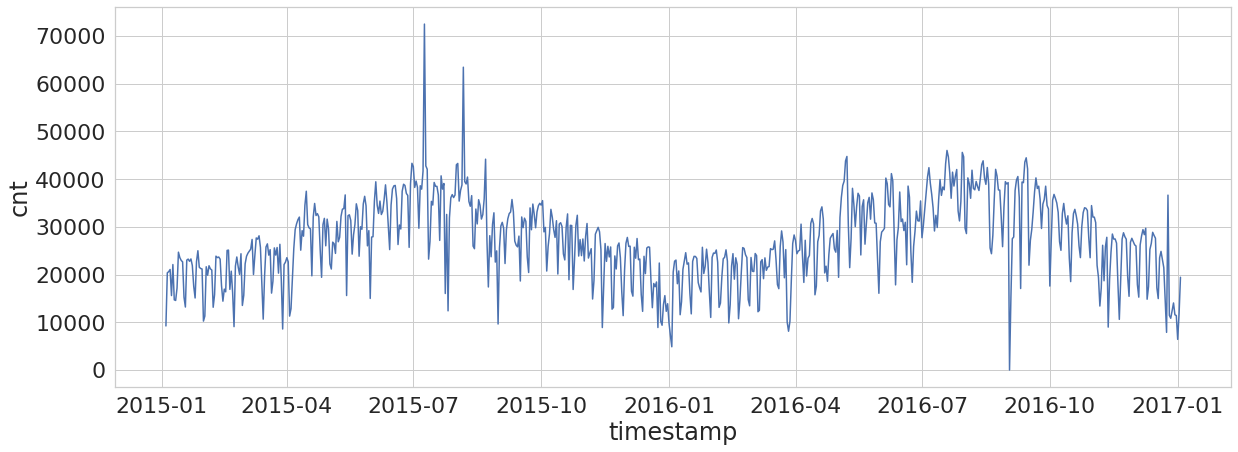

In [46]:
# способ 1
# data.resample(rule='D').column_name.sum()
# способ 2
# data.resample(rule='D').agg({'column_name':'sum'})

lon.timestamp = lon.timestamp.sort_values()
lon2 = (lon.set_index('timestamp')).resample(rule='D').cnt.sum().reset_index()
sns.lineplot(x = 'timestamp', y = 'cnt', data = lon2)

Итак, вы обнаружили на графике некоторые скачки. Давайте проверим, что же могло произойти в те дни - и насколько эти изменения для нас неожиданны 🤔. Для этого мы попробуем построить доверительный интервал вокруг данных - всё, что выпадает за его пределы, будет считаться аномалией, и на отдельные из них мы потом и посмотрим.

Однако не всё так просто. Мы сейчас работаем с временным рядом - последовательностью значений, меняющейся во времени. Мы не можем просто так посчитать доверительный интервал для всего: так мы можем упустить важные характеристики данных! Например, сезонные колебания. 

Чтобы учесть этот момент, мы построим доверительный интервал, используя скользящее среднее. Для этого разделим дальнейшие действия на несколько этапов:

сначала посчитаем скользящее среднее, чтобы сгладить ряд
далее – разницу между наблюдаемыми и сглаженными значениями
определим верхние и нижние границы 99% доверительного интервала 
найдем причины аномалий!
На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

In [52]:
lon2['rolling3'] = lon2.cnt.rolling(window=3).mean()
answer = lon2.query('timestamp == "2015-07-09"').rolling3
answer

186    50705.0
Name: rolling3, dtype: float64

Теперь посчитайте разницу между наблюдаемыми и подсчитанными значениями. Далее – примените функцию для подсчета стандартного отклонения.

В качестве ответа введите полученное стандартное отклонение, округленное до 2 знаков после точки.

In [56]:
std = np.std(lon2.cnt - lon2.rolling3)
round(std, 2)

4558.59

Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
lower_bound – нижняя граница; вычитаем 2.576∗std
Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения? Ответ укажите с точностью до 2 знаков после точки.

Note: в качестве std нужно брать стандартное отклонение без округления.

Note 2: вам может понадобиться убрать даты из индекса - иногда из-за этого колонки могут не присваиваться в датафрейм. Вам пригодится .reset_index().

In [62]:
lon2['upper_bound'], lon2['lower_bound'] = lon2.rolling3 + (std * 2.576), lon2.rolling3 - (std * 2.576)
lon2.tail(3)

,timestamp,cnt,rolling3,upper_bound,lower_bound
728,2017-01-01,6421,9803.666667,21546.585854,-1939.252521
729,2017-01-02,11823,9889.333333,21632.252521,-1853.585854
730,2017-01-03,19436,12560.000000,24302.919188,817.080812


И наконец – изучим аномально высокие значения! Сначала выведите наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

В какой день значение числа аренд оказалось наибольшим? Укажите дату в формате 2020-12-31.

In [65]:
maxind = lon2.query('cnt > upper_bound').upper_bound.idxmax()
lon2.iloc[maxind]

timestamp      2015-07-09 00:00:00
cnt                          72504
rolling3                     50705
upper_bound                62447.9
lower_bound                38962.1
Name: 186, dtype: object

In [66]:
lon2.query('timestamp == "2016-09-02"')

,timestamp,cnt,rolling3,upper_bound,lower_bound
607,2016-09-02,0,26086.333333,37829.252521,14343.414146


In [68]:
lon2.query('cnt < lower_bound')

,timestamp,cnt,rolling3,upper_bound,lower_bound
130,2015-05-14,15609,28709.333333,40452.252521,16966.414146
189,2015-07-12,23240,36036.666667,47779.585854,24293.747479
201,2015-07-24,16034,31013.666667,42756.585854,19270.747479
232,2015-08-24,17400,29529.333333,41272.252521,17786.414146
314,2015-11-14,8898,21037.333333,32780.252521,9294.414146
607,2016-09-02,0,26086.333333,37829.252521,14343.414146
615,2016-09-10,17080,31262.000000,43004.919188,19519.080812
621,2016-09-16,21967,36193.333333,47936.252521,24450.414146
678,2016-11-12,8990,20878.000000,32620.919188,9135.080812
